# REINFORCE

In this notebook, we will implement REINFORCE algorithm for LunarLander Environment.

## Lunar Lander

This environment is a classic rocket trajectory optimization problem. The landing pad is always at coordinates (0,0). The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

There are four discrete actions available:<br>
- 0: do nothing<br>
- 1: fire left orientation engine<br>
- 2: fire main engine<br>
- 3: fire right orientation engine<br>

After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.

- is increased/decreased the slower/faster the lander is moving.

- is decreased the more the lander is tilted (angle not horizontal).

- is increased by 10 points for each leg that is in contact with the ground.

- is decreased by 0.03 points each frame a side engine is firing.

- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.


You can read more the LunarLander environment [here](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

![LunarLander](https://gymnasium.farama.org/_images/lunar_lander.gif)

## Reinforce

REINFORCE is an elegant algorithm for maximizing the expected return. We sample a trajectory $\tau$ . If we get a high reward, we try to make it more likely. If we get a low reward, we try to make it less likely.

We just need a policy that maximizes the expected return and we can do this by Gradient Ascent on Policy parameters.

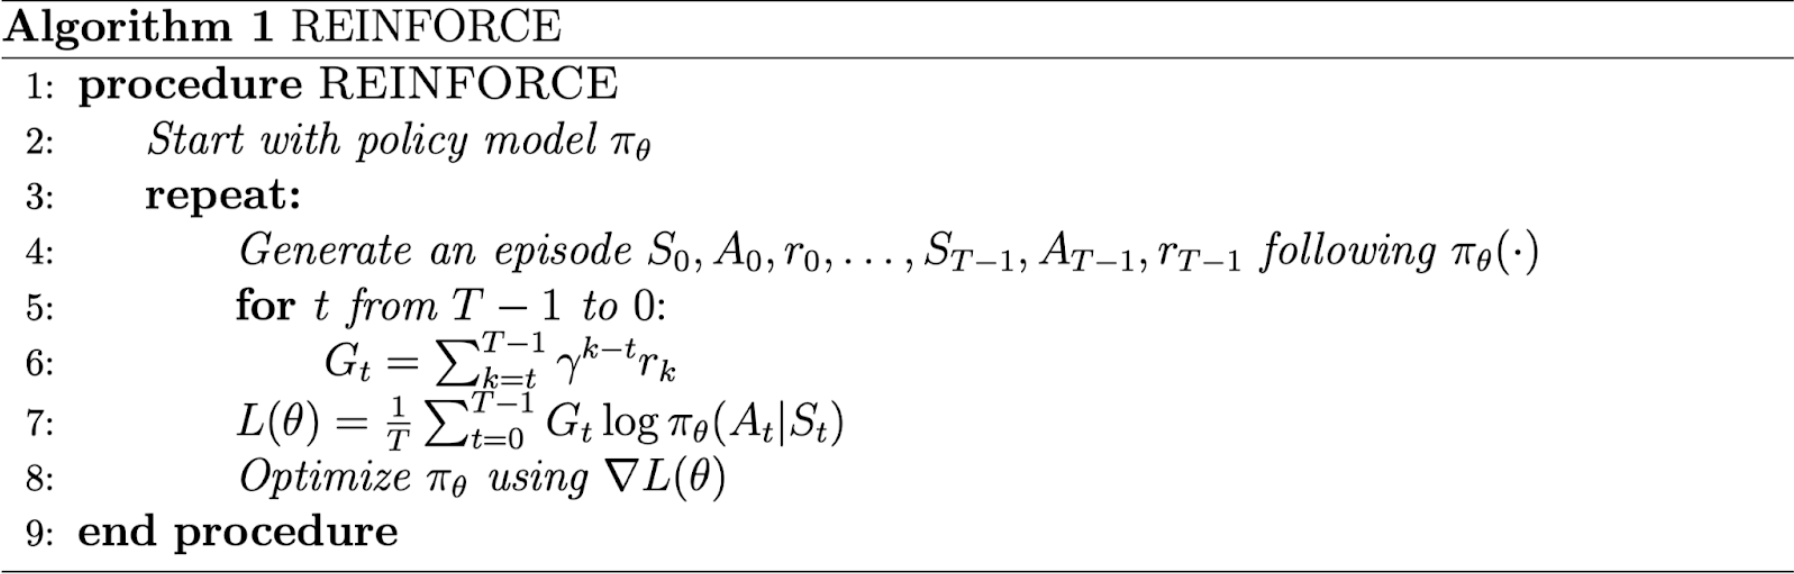


[Image Source](https://colab.research.google.com/github/huggingface/deep-rl-class/blob/master/notebooks/unit4/unit4.ipynb)

In [ ]:
!pip install -q swig
!pip install -q gym[box2d]

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
# Create the environment
env = gym.make("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Policy Network

In [ ]:
# A neural network for policy
# It takes the state as input and predicts the probability of each action

class Policy(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(Policy, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

### Hyperparameters

In [ ]:
# Here, we will specify the hyperparameters

total_episodes = 3000        # Total training episodes
max_steps = 1500              # Max steps per episode
learning_rate = 1e-3         # Learning rate
gamma = 0.99                 # Discounting rate

### Training

In [ ]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print('state size:', state_size)
print('action size:', action_size)

observation space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
action space: Discrete(4)
state size: 8
action size: 4


In [ ]:
# Intialize policy network
policy_net = Policy(state_size, action_size).to(device)

policy_net.load_state_dict(torch.load("/content/gdrive/MyDrive/Colab Notebooks/rl_summer_school/models/hw2_policy_net.pt", map_location=torch.device(device)))

# set up the optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

In [ ]:
scores = []
avg_scores = []
for episode in range(1, total_episodes+1):
  saved_log_probs = []
  rewards = []
  state = env.reset()
  # collect trajectory
  for t in range(max_steps):
    # sample action and its log probability from policy
    action, log_prob = policy_net.act(state)
    # save the log probability for later use
    saved_log_probs.append(log_prob)
    state, reward, done, _ = env.step(action)
    rewards.append(reward)
    if done:
        break

  scores.append(sum(rewards))
  avg_scores.append(sum(scores)/episode)

  # Compute the discounted returns at each timestep
  returns = deque(maxlen=max_steps)
  n_steps = len(rewards)
  # We will use the dynamic programming approach to reduce complexity of this operation.
  # We calculate from last to first and avoid redundant computations that would be needed
  # if we were to do it from first to last.

  for t in range(n_steps)[::-1]:
    disc_return_t = (returns[0] if len(returns)>0 else 0)
    returns.appendleft( gamma*disc_return_t + rewards[t])

  ## standardization of the returns is employed to make training more stable
  eps = np.finfo(np.float32).eps.item()
  ## eps is the smallest representable float, which is
  # added to the standard deviation of the returns to avoid numerical instabilities
  returns = torch.tensor(returns)
  returns = (returns - returns.mean()) / (returns.std() + eps)

  # Calculating policy loss:
  policy_loss = []
  for log_prob, disc_return in zip(saved_log_probs, returns):
    # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
    policy_loss.append(-log_prob * disc_return)
  policy_loss = torch.cat(policy_loss).sum()

  # Back propagation
  optimizer.zero_grad()
  policy_loss.backward()
  optimizer.step()

  if scores[-1]>=200:
    print(f"Episode {episode}: Reward = {scores[-1]}\t Success!")
  else:
    print(f"Episode {episode}: Reward = {scores[-1]}")

  if episode % 200 == 0:
    print('saving model')
    torch.save(policy_net.state_dict(), "/content/gdrive/MyDrive/Colab Notebooks/rl_summer_school/models/hw2_policy_net.pt")

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1: Reward = -512.4988163732272
Episode 2: Reward = -88.95960769461189
Episode 3: Reward = -171.18234379001984
Episode 4: Reward = -125.8453540742472
Episode 5: Reward = -119.40246268510754
Episode 6: Reward = -341.1330540372509
Episode 7: Reward = -146.9726496488133
Episode 8: Reward = -113.6844035264095
Episode 9: Reward = -68.6669488091275
Episode 10: Reward = -98.29024049140578
Episode 11: Reward = -113.76713536648377
Episode 12: Reward = -238.71522468732854
Episode 13: Reward = -277.34571071372557
Episode 14: Reward = -325.89893764872755
Episode 15: Reward = -235.71275645943712
Episode 16: Reward = -149.76127944451488
Episode 17: Reward = -136.4039475518677
Episode 18: Reward = -126.52480057825738
Episode 19: Reward = -208.38139735984572
Episode 20: Reward = -30.322390302353412
Episode 21: Reward = -184.31142074215995
Episode 22: Reward = -146.78737788227193
Episode 23: Reward = -330.4227956541645
Episode 24: Reward = -155.28837128314996
Episode 25: Reward = -127.3562812898

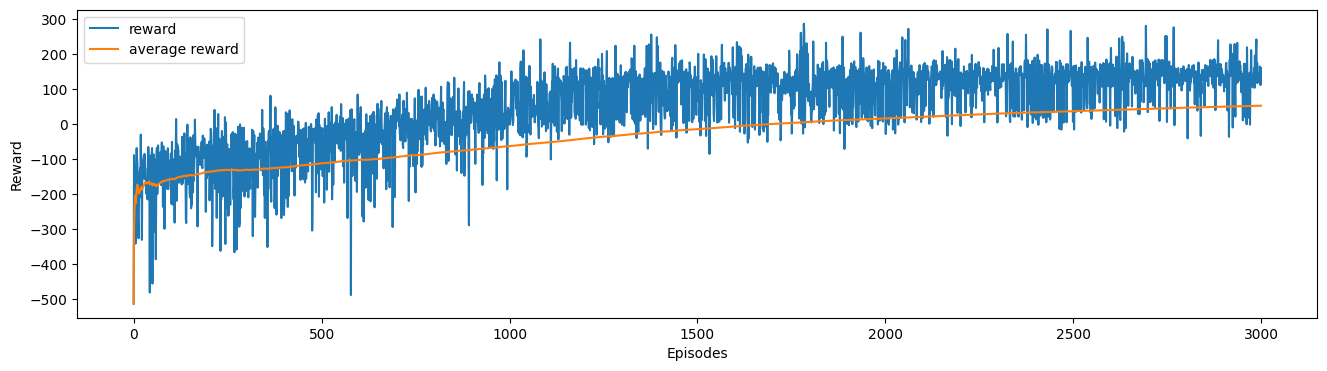

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(scores, label='reward')
plt.plot(avg_scores, label='average reward')
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()

In [ ]:
policy_net.load_state_dict(torch.load("/content/gdrive/MyDrive/Colab Notebooks/rl_summer_school/models/hw2_policy_net.pt", map_location=torch.device(device)))

<All keys matched successfully>

### Visualization

In [ ]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(max_steps):
        while not done:
          vid.capture_frame()
          action, log_prob = policy_net.act(state)
          next_state, reward, done, info = env.step(action)
          state = next_state
        break
    vid.close()
    env.close()

show_video_of_model("LunarLander-v2")
show_video("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
